# TelcoX Churn Machine Learning

This notebook is the continuation of `telco-churn_eda.ipynb`. Once we know better the nature of our data, we can start thinking about creating a model which can infer from new customer data if they are going to churn or not.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
import joblib

from xgboost import XGBClassifier
from skopt import BayesSearchCV

plt.style.use('seaborn-v0_8-pastel')

import sys
sys.path.append('../lib')

from config import RED, BLUE, MODEL_FOLDER

In [2]:
def preprocessing(df):
    '''
    Get the original dataframe and returns a copy with some preprocessing on data
    '''  
    X = df.copy()

    # Fix empty values in Total Charges with np.nan and cast the var into a float
    empty_vals = X[X['TotalCharges'].apply(lambda x: bool(re.match('\D+', x)))]['TotalCharges'].unique()
    for empty_val in empty_vals:
        X.loc[X['TotalCharges']==empty_val, ['TotalCharges']] = np.nan

    X['TotalCharges'] = X['TotalCharges'].astype(float)

    assert (X.loc[X['TotalCharges'].isnull(), 'tenure'] == 0).all(), 'Missing Total Charge corresponding to a tenure not 0'

    # We discover that these missing values are corresponding to tenure 0 customers so let's fill them.
    X['TotalCharges'].fillna(0, inplace=True)

    # Fix Monthly Charges missing. When there're no charges, it is 0 and otherwise the total/n_months
    X.loc[X['MonthlyCharges'].isnull()&(X['TotalCharges']==0), 'MonthlyCharges'] = 0
    X.loc[X['MonthlyCharges'].isnull()&(X['TotalCharges']>0), 'MonthlyCharges'] = X['TotalCharges'] / X['tenure']

    # Many of the variables have 'No internet service' as category. This is redundant because there's already
    # a variable for that. Let's put it on zero so that we convert them in binary vars
    cols_no_int = list(X[X == 'No internet service'].dropna(axis=1, how='all').columns)
    X[cols_no_int] = X.loc[:, cols_no_int].apply(lambda col: col.map({'Yes':1, 'No':0, 'No internet service':0}))

    # Now we can add internet service as a variable
    df_multlines = pd.get_dummies(X['MultipleLines']).rename(columns={'Yes':'MultipleLines', 
                                                                        'No phone service':'No_Phone'})
    df_multlines = df_multlines[['MultipleLines', 'No_Phone']]
    X = pd.concat([X.drop(columns=['MultipleLines']), df_multlines], axis=1)

    # Let's convert Yes and No into 0 and 1
    cols_yes_no = list(X[(X == 'Yes')|(X == 'No')].dropna(axis=1, how='any').columns)
    X[cols_yes_no] = X[cols_yes_no].apply(lambda col: col.map({'Yes':1, 'No':0}))

    # The same with gender
    X['Male'] = X['gender'].map({'Male':1, 'Female':0})
    X.drop(columns='gender', inplace=True)
    
    # Finally, we encode the rest of the object vars
    obj_cols = X.dtypes[X.dtypes=='O'].index
    X = pd.get_dummies(X, columns=obj_cols)

    return X

# Read Data

First of all, `train` and `test` raw data is read and processed imputing missing values using common sense and information from each register.

In [3]:
# Read train and test data
df_train_orig = pd.read_csv('../data/train.csv')
df_test_orig = pd.read_csv('../data/test.csv')

X = preprocessing(df_train_orig)
y = X.pop('Churn')

X_test = preprocessing(df_test_orig)

Conjunto de entrenamiento

In [4]:
X.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,11,1,0,1,0,0,1,...,0,1,0,1,0,0,0,0,1,0
1,0,1,1,66,1,0,0,1,0,1,...,1,0,0,0,0,1,1,0,0,0
2,0,1,1,71,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,0,1,0,31,1,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
4,0,1,1,62,1,1,1,1,1,1,...,1,0,0,0,0,1,0,0,1,0


Conjunto de test

In [5]:
X_test.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,72,1,1,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,0,1,0,57,1,0,1,1,1,1,...,1,0,0,0,1,0,1,0,0,0
2,1,0,0,46,1,0,0,1,1,0,...,1,0,0,0,1,0,0,1,0,0
3,0,1,1,38,1,0,0,1,0,1,...,0,1,0,1,0,0,0,1,0,0
4,1,1,0,32,1,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0


# Correlations

They have been already analyzed in the EDA but we check them again.

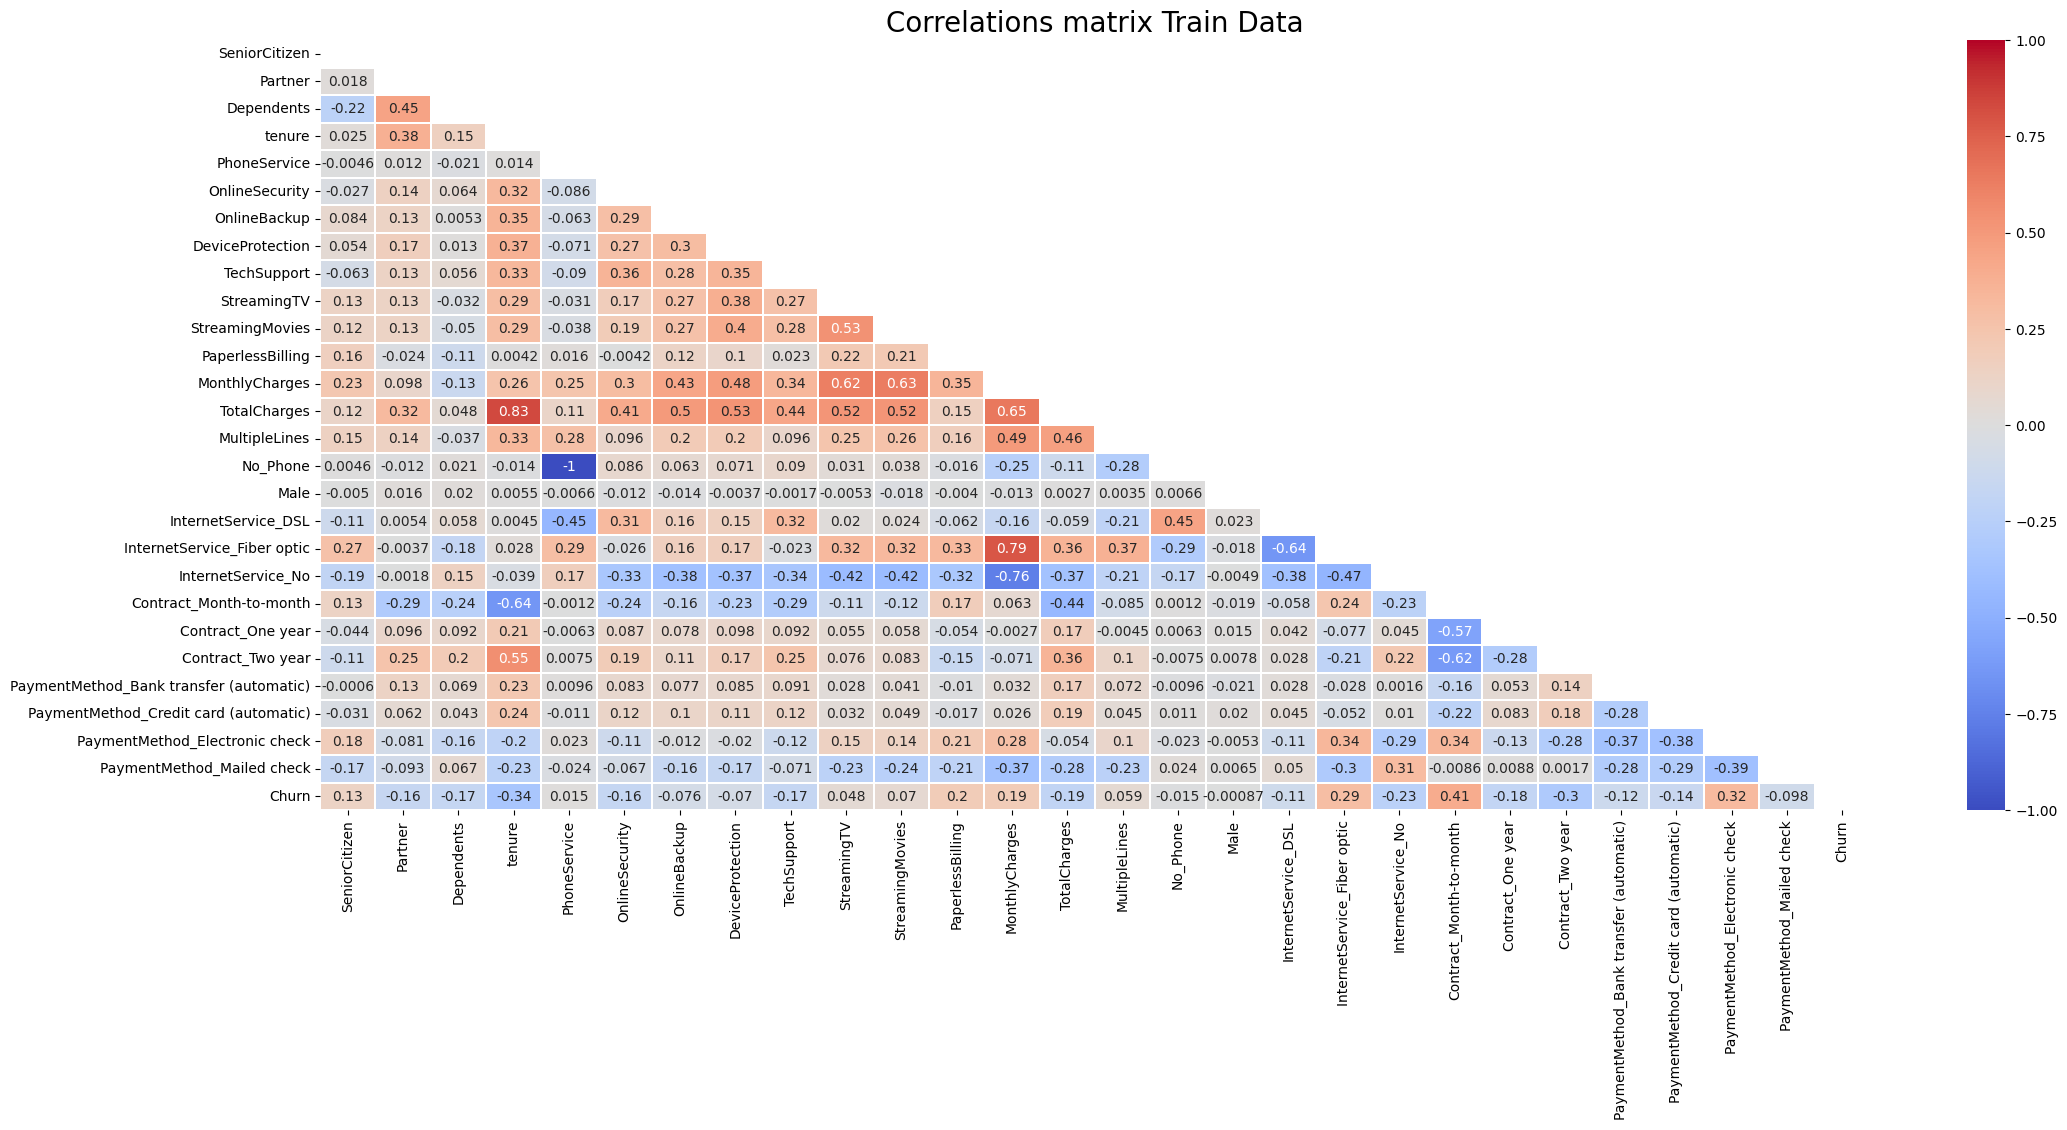

In [6]:
plt.figure(figsize=(25, 10))
corr = pd.concat([X, y], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title('Correlations matrix Train Data', fontsize=20);

# Model Selection

# Imbalanced Data

In this problem, there is some imbalanced data we have to deal with. As we can observe, the ratio of churn is 3 times lower than the rest of them. This means that if we start with a naive model which always predicts that there's not going to be churn, we would have a 72.73% of accuracy. This doesn't represent at all the quality of the model.

In this case, given that losing a customer is much worse than giving a voucher to a client who is not going to churn, our goal is to minimize False Negatives.

<AxesSubplot: title={'center': 'Target distribution'}, ylabel='Churn'>

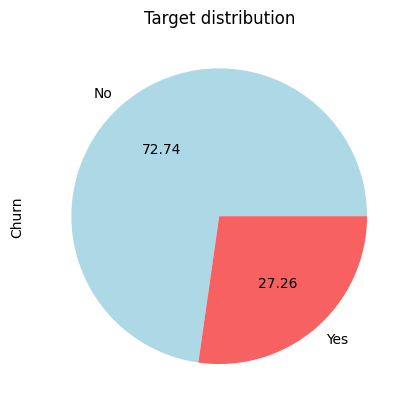

In [7]:
df_train_orig['Churn'].value_counts().plot(kind='pie', autopct='%.2f', title='Target distribution', colors=[BLUE, RED])

Now we can make a partition of the data into train-val

In [8]:
y

0       1
1       0
2       0
3       0
4       0
       ..
4207    0
4208    0
4209    0
4210    1
4211    0
Name: Churn, Length: 4212, dtype: int64

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8, random_state=0, stratify=y)

print('Train data: ', X_train.shape)
print('Validation data: ', X_val.shape)

Train data:  (3369, 27)
Validation data:  (843, 27)


<AxesSubplot: title={'center': 'Validation target distribution'}>

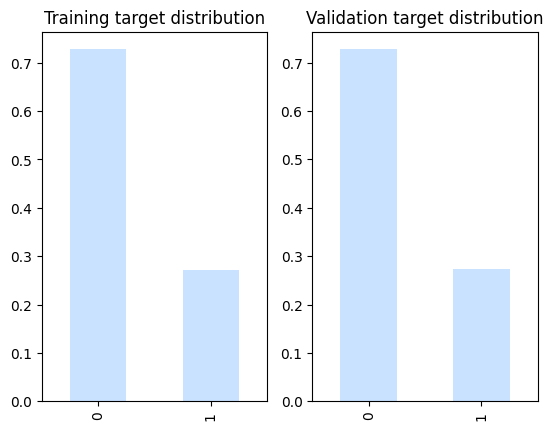

In [10]:
fig, ax = plt.subplots(1, 2)
y_train.value_counts(normalize=True).plot(kind='bar', alpha=.5, ax=ax[0], title='Training target distribution')
y_val.value_counts(normalize=True).plot(kind='bar', alpha=.5, ax=ax[1], title='Validation target distribution')

## Logistic Regression

Parameters:

- Penalty: Kind of penalty `L_1` or `L_2` introduced to the cost function. The first one allows 0 valued coefficients so it is more efficient from a computational point of view.
- C: Inverse of regularization strength. 


In [11]:
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
not_num_cols = [col for col in X.columns if col not in num_cols]


# # scaler and encoder options
# my_scaler = ScalerSelector()

preprocessor = ColumnTransformer([
                                    ('num', StandardScaler(), num_cols),
                                    ('cat', FunctionTransformer(), not_num_cols)
                                ])

# combine the preprocessor with LogisticRegression() using Pipeline 
full_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression())
                                  ])

logistic_params = {
    'classifier': [LogisticRegression(solver='liblinear')],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.linspace(0.1, 2, 20)
    }

# Repeats the CV n times
cv = StratifiedKFold(n_splits=5)


# Create grid search 
clf_clr = GridSearchCV(estimator=full_pipeline,
                        param_grid=logistic_params,
                        cv=cv,
                        scoring='roc_auc',
                        verbose=0,
                        n_jobs=-1)

# Fit grid search
best_model = clf_clr.fit(X_train, y_train)
# View best model
separator = "/n############################/n"
print(separator)
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print(separator)
print("clf.best_params_", clf_clr.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_clr.best_score_)

/n############################/n
best estimator: LogisticRegression(C=0.6, penalty='l1', solver='liblinear')
/n############################/n
clf.best_params_ {'classifier': LogisticRegression(C=0.6, penalty='l1', solver='liblinear'), 'classifier__C': 0.6, 'classifier__penalty': 'l1'}
/n############################/n
clf.best_score 0.841508763251001


In [12]:
# save the model to disk
filepath = os.path.join(os.path.relpath('../models'), 'LOGISTIC', datetime.strftime(datetime.now(), '%d_%m_%y-%H_%M_%S'))
if not os.path.exists(filepath):
  # Create a new directory because it does not exist 
  os.makedirs(filepath)
  print(f"The {filepath} folder is created!")

filename = os.path.join(filepath, 'model.sav')
with open(filename, "wb") as archivo_salida:
    joblib.dump(best_model.best_estimator_, archivo_salida)

# SAVE CV RESULTS
filename_res = os.path.join(filepath, 'results.csv')
df_res = pd.DataFrame(clf_clr.cv_results_).sort_values(by='rank_test_score')
df_res.to_csv(filename_res)

The ..\models\LOGISTIC\15_11_22-01_35_24 folder is created!


In [13]:
df_res[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.062494,0.033896,0.004801,0.003920,"LogisticRegression(C=0.6, penalty='l1', solver...",0.6,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824756,0.830058,0.848763,0.870455,0.833512,0.841509,0.016530,1
12,0.080491,0.024356,0.002904,0.003589,"LogisticRegression(C=0.6, penalty='l1', solver...",0.7,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824579,0.830013,0.848641,0.870544,0.833657,0.841487,0.016579,2
8,0.054282,0.013584,0.004804,0.003923,"LogisticRegression(C=0.6, penalty='l1', solver...",0.5,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824900,0.830069,0.848719,0.870388,0.833356,0.841486,0.016488,3
16,0.051069,0.013097,0.008814,0.001298,"LogisticRegression(C=0.6, penalty='l1', solver...",0.9,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824434,0.829825,0.848652,0.870689,0.833701,0.841460,0.016682,4
14,0.090436,0.011956,0.006007,0.003037,"LogisticRegression(C=0.6, penalty='l1', solver...",0.8,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824445,0.829803,0.848652,0.870633,0.833735,0.841454,0.016661,5
18,0.066394,0.017274,0.005102,0.003259,"LogisticRegression(C=0.6, penalty='l1', solver...",1.0,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824479,0.829836,0.848586,0.870678,0.833690,0.841454,0.016663,6
38,0.167274,0.071982,0.017442,0.012930,"LogisticRegression(C=0.6, penalty='l1', solver...",2.0,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824323,0.829647,0.848730,0.870878,0.833523,0.841420,0.016819,7
24,0.128392,0.054603,0.005065,0.003657,"LogisticRegression(C=0.6, penalty='l1', solver...",1.3,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824346,0.829714,0.848619,0.870711,0.833701,0.841418,0.016721,8
30,0.124226,0.055222,0.006604,0.003544,"LogisticRegression(C=0.6, penalty='l1', solver...",1.6,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824213,0.829714,0.848741,0.870800,0.833579,0.841409,0.016801,9
22,0.104685,0.021887,0.017595,0.027427,"LogisticRegression(C=0.6, penalty='l1', solver...",1.2,l1,"{'classifier': LogisticRegression(C=0.6, penal...",0.824290,0.829758,0.848530,0.870733,0.833679,0.841398,0.016728,10


Testing on validation this is the result

In [96]:
y_pred = best_model.predict(X_val)
score = roc_auc_score(y_true=y_val, y_score=best_model.predict_proba(X_val)[:,1])
print(score)


0.818703454145684


<AxesSubplot: >

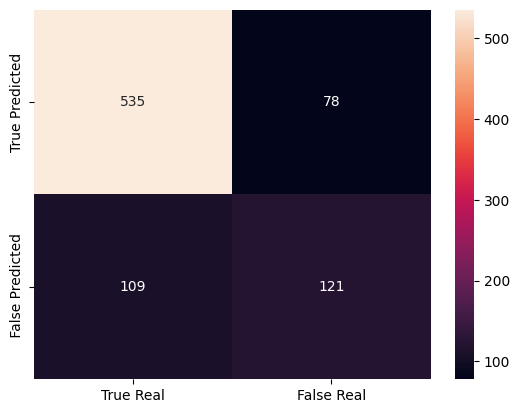

In [42]:
cf = confusion_matrix(y_true=y_val, y_pred=y_pred)
cf = pd.DataFrame(cf, columns=['True Real', 'False Real'], index=['True Predicted', ' False Predicted'])
sns.heatmap(cf, annot=True, fmt='.0f')

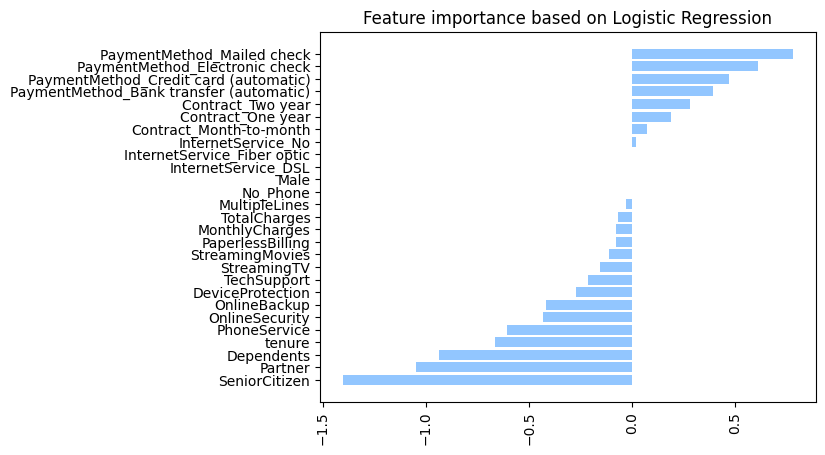

In [43]:
coefs = best_model.best_estimator_.get_params()['classifier'].coef_
plt.barh(y=list(X.columns), width=sorted(coefs.reshape(-1)))
plt.xticks(rotation=90)
plt.title('Feature importance based on Logistic Regression');

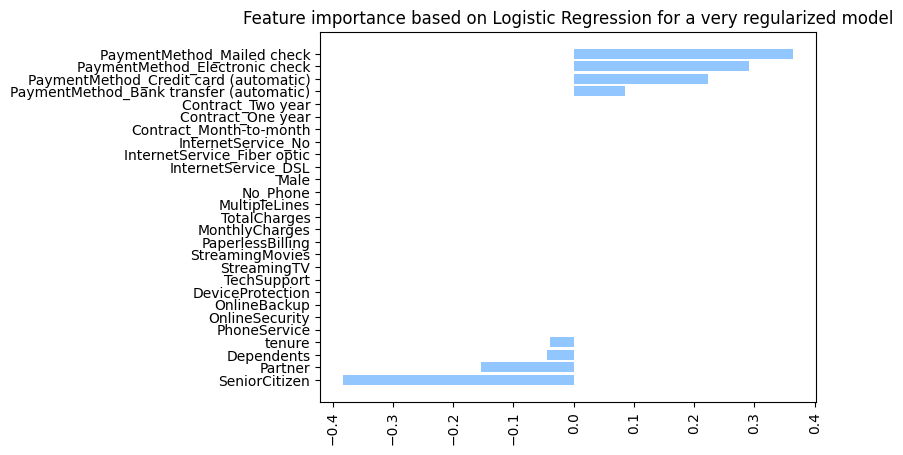

In [97]:
mod_overfit = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
sc = StandardScaler()
mod_overfit.fit(sc.fit_transform(X_train), y_train)

coefs = mod_overfit.coef_
plt.barh(y=list(X.columns), width=sorted(coefs.reshape(-1)))
plt.xticks(rotation=90)
plt.title('Feature importance based on Logistic Regression for a very regularized model');

## Random Forest

In [99]:
random_forest_params = {
    'classifier': [RandomForestClassifier(oob_score=True)],
    'classifier__n_estimators': [10, 100, 1000],
    'classifier__max_features': range(4, 11, 2),
    'classifier__min_samples_leaf': range(2, 11, 2)
    }


# Create grid search 
clf_rf = GridSearchCV(estimator=full_pipeline,
                        param_grid=[random_forest_params],
                        cv=cv,
                        scoring='roc_auc',
                        verbose=0,
                        n_jobs=-1)

# Fit grid search
best_model_rf = clf_rf.fit(X_train, y_train)
# View best model
separator = "/n############################/n"
print(separator)
print("best estimator:", best_model_rf.best_estimator_.get_params()['classifier'])
print(separator)
print("clf.best_params_", clf_rf.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_rf.best_score_)

/n############################/n
best estimator: RandomForestClassifier(max_features=4, min_samples_leaf=10, n_estimators=1000,
                       oob_score=True)
/n############################/n
clf.best_params_ {'classifier': RandomForestClassifier(max_features=4, min_samples_leaf=10, n_estimators=1000,
                       oob_score=True), 'classifier__max_features': 4, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 1000}
/n############################/n
clf.best_score 0.8457048506670132


Let's check its behaviour on thw Out Of Bagging samples

In [100]:
best_model_rf.best_estimator_.get_params()['classifier'].oob_score_

0.8002374591867023

In [101]:
# save the model to disk
filepath = os.path.join(os.path.relpath('../models'), 'RANDOM_FOREST', datetime.strftime(datetime.now(), '%d_%m_%y-%H_%M_%S'))
if not os.path.exists(filepath):
  # Create a new directory because it does not exist 
  os.makedirs(filepath)
  print(f"The {filepath} folder is created!")

filename = os.path.join(filepath, 'model.sav')
with open(filename, "wb") as archivo_salida:
    joblib.dump(best_model_rf.best_estimator_, archivo_salida)

# SAVE CV RESULTS
filename_res = os.path.join(filepath, 'results.csv')
df_res = pd.DataFrame(clf_rf.cv_results_).sort_values(by='rank_test_score')
df_res.to_csv(filename_res)

The ..\models\RANDOM_FOREST\14_11_22-00_15_19 folder is created!


In [24]:
pd.DataFrame(clf_rf.cv_results_).sort_values(by='rank_test_score')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__max_features,param_classifier__min_samples_leaf,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,3.858208,0.085063,0.207014,0.011039,"RandomForestClassifier(max_features=4, min_sam...",4,10,1000,{'classifier': RandomForestClassifier(max_feat...,0.827751,0.835160,0.857293,0.869598,0.839512,0.845863,0.015342,1
11,3.755706,0.077659,0.209475,0.014490,"RandomForestClassifier(max_features=4, min_sam...",4,8,1000,{'classifier': RandomForestClassifier(max_feat...,0.827418,0.836679,0.855219,0.869097,0.840604,0.845803,0.014694,2
13,0.359296,0.010166,0.024425,0.001578,"RandomForestClassifier(max_features=4, min_sam...",4,10,100,{'classifier': RandomForestClassifier(max_feat...,0.826764,0.836358,0.854786,0.869565,0.841257,0.845746,0.014951,3
7,0.460361,0.044558,0.029486,0.009791,"RandomForestClassifier(max_features=4, min_sam...",4,6,100,{'classifier': RandomForestClassifier(max_feat...,0.829154,0.834339,0.852812,0.866705,0.841129,0.844827,0.013503,4
8,4.105693,0.050258,0.203368,0.003016,"RandomForestClassifier(max_features=4, min_sam...",4,6,1000,{'classifier': RandomForestClassifier(max_feat...,0.826830,0.834749,0.853244,0.868975,0.839668,0.844693,0.014872,5
29,7.211273,0.362335,0.323119,0.024291,"RandomForestClassifier(max_features=4, min_sam...",6,10,1000,{'classifier': RandomForestClassifier(max_feat...,0.827518,0.835603,0.853743,0.867539,0.838173,0.844515,0.014310,6
26,7.606959,0.266279,0.343865,0.049316,"RandomForestClassifier(max_features=4, min_sam...",6,8,1000,{'classifier': RandomForestClassifier(max_feat...,0.827196,0.833818,0.852146,0.869186,0.837538,0.843977,0.015023,7
28,0.679476,0.079586,0.041492,0.007998,"RandomForestClassifier(max_features=4, min_sam...",6,10,100,{'classifier': RandomForestClassifier(max_feat...,0.828172,0.833219,0.852468,0.865569,0.838212,0.843528,0.013683,8
25,0.778851,0.117138,0.059665,0.049396,"RandomForestClassifier(max_features=4, min_sam...",6,8,100,{'classifier': RandomForestClassifier(max_feat...,0.826276,0.831954,0.853100,0.868107,0.837794,0.843446,0.015233,9
10,0.413743,0.025322,0.028434,0.004924,"RandomForestClassifier(max_features=4, min_sam...",4,8,100,{'classifier': RandomForestClassifier(max_feat...,0.824889,0.834971,0.853433,0.865235,0.838642,0.843434,0.014239,10


0.8287679977303355


<AxesSubplot: >

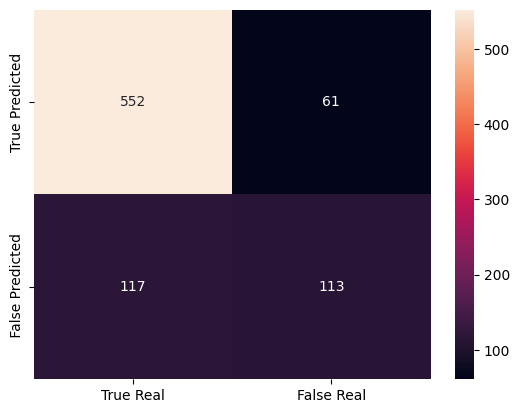

In [115]:
y_pred_rf = best_model_rf.predict(X_val)
score = roc_auc_score(y_true=y_val, y_score=best_model_rf.predict_proba(X_val)[:,1])
print(score)


cf = confusion_matrix(y_true=y_val, y_pred=y_pred_rf)
cf = pd.DataFrame(cf, columns=['True Real', 'False Real'], index=['True Predicted', ' False Predicted'])
sns.heatmap(cf, annot=True, fmt='.0f')

Text(0.5, 1.0, 'Feature Importances Random Forest')

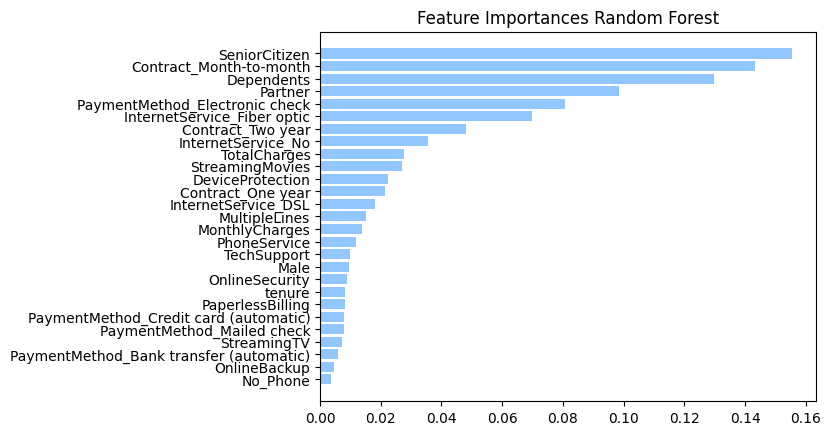

In [45]:
importances = best_model_rf.best_estimator_.get_params()['classifier'].feature_importances_
df_importances = pd.DataFrame({'features':X.columns, 'importances':importances}).sort_values(by='importances')
plt.barh(y=df_importances.features, width=df_importances.importances)
plt.title('Feature Importances Random Forest')

## Gradient Boosting

In [105]:
from skopt.space import Real, Categorical, Integer

In [109]:
# xgb_params = {
#     'classifier': [XGBClassifier()],
#     'classifier__gamma': [0, 0.5, 1, 10, 50, 100],
#     'classifier__learning_rate': [.01, .1, .5],
#     'classifier__max_depth': [2, 4, 6],
#     'classifier__n_estimators': [50, 100],
#     'classifier__reg_alpha': [0, .1, 1],
#     'classifier__reg_lambda': [0, .1, 1]}

search_spaces = {'classifier': [XGBClassifier()],
                'classifier__learning_rate': Real(0.01, 1.0, 'uniform'),
                 'classifier__max_depth': Integer(2, 12),
                 'classifier__subsample': Real(0.1, 1.0, 'uniform'),
                 'classifier__colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'classifier__reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'classifier__reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'classifier__n_estimators': Integer(50, 5000)
   }

# Create grid search 
clf_xgb = BayesSearchCV(estimator=full_pipeline,
                        search_spaces=search_spaces,
                        n_iter=60,
                        cv=cv,
                        scoring='roc_auc',
                        verbose=0,
                        n_jobs=-1)

# Fit grid search
best_model_xgb = clf_xgb.fit(X_train, y_train)
# View best model
separator = "/n############################/n"
print(separator)
print("best estimator:", best_model_xgb.best_estimator_.get_params()['classifier'])
print(separator)
print("clf.best_params_", clf_xgb.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_xgb.best_score_)

/n############################/n
best estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.33949727446068867, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1279267793036371,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2061,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)
/n############################/n
clf.best_params_ OrderedDict([('classifier', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
           

In [111]:
pd.DataFrame(clf_xgb.cv_results_).sort_values(by='rank_test_score')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__reg_alpha,...,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,2.910063,0.031605,0.014613,0.002079,"XGBClassifier(base_score=None, booster=None, c...",0.339497,0.127927,4,2061,20.87579,...,0.488022,"{'classifier': XGBClassifier(base_score=None, ...",0.827052,0.837206,0.859921,0.867912,0.841859,0.846790,0.014996,1
56,5.296330,0.074158,0.039546,0.004784,"XGBClassifier(base_score=None, booster=None, c...",0.1,0.01,9,5000,4.020103,...,0.532136,"{'classifier': XGBClassifier(base_score=None, ...",0.831888,0.834317,0.857082,0.867228,0.842734,0.846650,0.013547,2
20,2.214391,0.090994,0.029899,0.002837,"XGBClassifier(base_score=None, booster=None, c...",0.148999,0.01,6,693,0.0,...,0.463378,"{'classifier': XGBClassifier(base_score=None, ...",0.830612,0.834894,0.852368,0.866693,0.841720,0.845257,0.012996,3
16,0.984806,0.017348,0.027537,0.011883,"XGBClassifier(base_score=None, booster=None, c...",1.0,0.318448,10,50,20.130089,...,1.0,"{'classifier': XGBClassifier(base_score=None, ...",0.821778,0.833463,0.857293,0.862915,0.841145,0.843319,0.015134,4
38,1.298438,0.041811,0.010648,0.000907,"XGBClassifier(base_score=None, booster=None, c...",0.606685,0.14144,7,1117,36.299445,...,0.712849,"{'classifier': XGBClassifier(base_score=None, ...",0.819354,0.835476,0.860847,0.861279,0.838580,0.843107,0.016049,5
37,0.064908,0.005752,0.005979,0.000894,"XGBClassifier(base_score=None, booster=None, c...",0.471797,0.529599,2,50,0.0,...,0.930088,"{'classifier': XGBClassifier(base_score=None, ...",0.829902,0.831777,0.851159,0.865263,0.837214,0.843063,0.013366,6
57,4.349823,0.051204,0.019993,0.002831,"XGBClassifier(base_score=None, booster=None, c...",0.1,0.01,6,5000,28.127556,...,0.666991,"{'classifier': XGBClassifier(base_score=None, ...",0.819870,0.832914,0.861668,0.863650,0.835781,0.842777,0.017108,7
1,2.187406,0.032358,0.010866,0.002227,"XGBClassifier(base_score=None, booster=None, c...",0.584674,0.540914,2,2198,36.900249,...,0.456588,"{'classifier': XGBClassifier(base_score=None, ...",0.819526,0.834084,0.857770,0.862659,0.836238,0.842055,0.015977,8
36,7.104118,0.019286,0.039775,0.002739,"XGBClassifier(base_score=None, booster=None, c...",0.471122,0.01,4,2316,0.0,...,0.573163,"{'classifier': XGBClassifier(base_score=None, ...",0.827806,0.830501,0.850438,0.863277,0.838062,0.842017,0.013214,9
5,0.929599,0.028156,0.012449,0.002607,"XGBClassifier(base_score=None, booster=None, c...",0.639377,0.82256,7,758,12.067089,...,0.967715,"{'classifier': XGBClassifier(base_score=None, ...",0.823519,0.830185,0.854437,0.864250,0.837387,0.841956,0.015180,10


In [112]:
# save the model to disk
filepath = os.path.join(os.path.relpath('../models'), 'XGB', datetime.strftime(datetime.now(), '%d_%m_%y-%H_%M_%S'))
if not os.path.exists(filepath):
  # Create a new directory because it does not exist 
  os.makedirs(filepath)
  print(f"The {filepath} folder is created!")

filename = os.path.join(filepath, 'model.sav')
with open(filename, "wb") as archivo_salida:
    joblib.dump(best_model_xgb.best_estimator_, archivo_salida)

# SAVE CV RESULTS
filename_res = os.path.join(filepath, 'results.csv')
df_res = pd.DataFrame(clf_xgb.cv_results_).sort_values(by='rank_test_score')
df_res.to_csv(filename_res)

The ..\models\XGB\14_11_22-00_46_32 folder is created!


Text(0.5, 1.0, 'Feature Importances XGBoost')

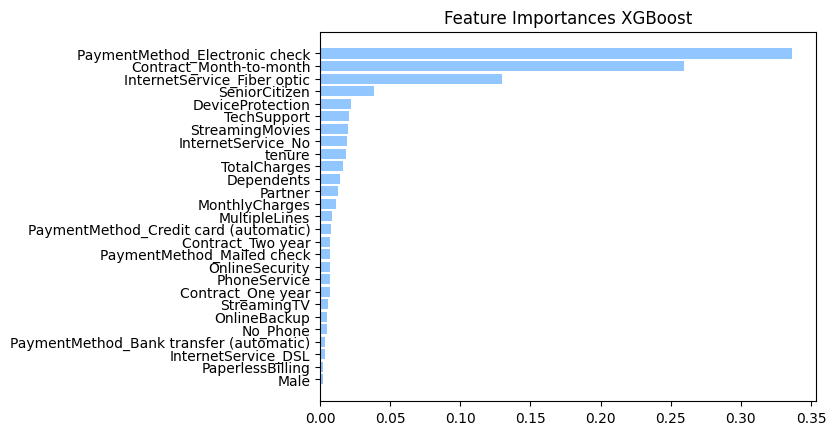

In [117]:
importances = best_model_xgb.best_estimator_.get_params()['classifier'].feature_importances_
df_importances = pd.DataFrame({'features':X.columns, 'importances':importances}).sort_values(by='importances')
plt.barh(y=df_importances.features, width=df_importances.importances)
plt.title('Feature Importances XGBoost')

0.8249946804737925


<AxesSubplot: >

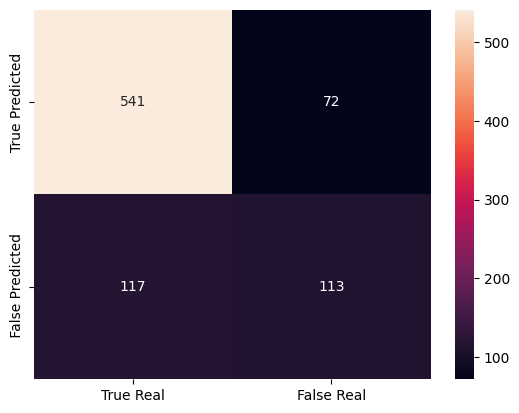

In [116]:
y_pred_xgb = best_model_xgb.predict(X_val)
score = roc_auc_score(y_true=y_val, y_score=best_model_xgb.predict_proba(X_val)[:,1])
print(score)


cf = confusion_matrix(y_true=y_val, y_pred=y_pred_xgb)
cf = pd.DataFrame(cf, columns=['True Real', 'False Real'], index=['True Predicted', ' False Predicted'])
sns.heatmap(cf, annot=True, fmt='.0f')

# Model Selection

Finally, let's choose one of the models and let's retrain it on all our labeled data. After that, we give an estimation of the test labels.

After the calcularions, we save the predictions and the probabilities.

In [14]:
with open('../models/RANDOM_FOREST/14_11_22-00_15_19/model.sav', 'rb') as f:
    model = joblib.load(f)

model.fit(X, y)

y_test = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

In [15]:
# save the model to disk
filepath = os.path.join(os.path.relpath('../predictions'), datetime.strftime(datetime.now(), '%d_%m_%y-%H_%M_%S'))
if not os.path.exists(filepath):
  # Create a new directory because it does not exist 
  os.makedirs(filepath)
  print(f"The {filepath} folder is created!")

filename = os.path.join(filepath, 'model.sav')
with open(filename, "wb") as archivo_salida:
    joblib.dump(model, archivo_salida)

# SAVE CV RESULTS
filename_res = os.path.join(filepath, 'test_preds.csv')
pd.DataFrame(y_test).to_csv(filename_res)

filename_prob = os.path.join(filepath, 'test_preds_proba.csv')
pd.DataFrame(y_test_proba).to_csv(filename_prob)

The ..\predictions\15_11_22-02_02_58 folder is created!
